In [2]:
import r3.adapters as adapters
import r3.schema as schema
from r3.models.hybrid_models.discrepancy_model import DiscrepancyIVTModel
from r3.models.assimulo.assimulo_model import AssimuloIVTModel
import xgboost
from matplotlib import pyplot as plt

# show the r2 score of the predictions
from sklearn.metrics import r2_score

X_columns = [schema.IVTReactionSchema.pH.value, schema.IVTReactionSchema.TIME_min.value]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]

experimental_conditions, responses = adapters.DataPipelineAdapter("ricardo_ph").get_all(
    X_columns=X_columns,
    y_columns=y_columns,
    paths=[["ricardo_ph", "egfptris"], ["ricardo_ph", "egfphepes"]],
    skip_initial_load=True,
)

X_train = experimental_conditions[0][1]
y_train = responses[0][1]

X_test = experimental_conditions[1][1]
y_test = responses[1][1]

assimulo_model = AssimuloIVTModel(
    template=schema.DNATemplates.eGFP, experiment_type=schema.ExperimentType.TIME_SERIES
)

experimental_data = X_train.copy()
experimental_data[schema.IVTReactionSchema.RNA_g_L.value] = y_train.values
assimulo_model.fit(experimental_data, y_columns, is_sequence=True)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\Kesler\anaconda3\envs\assimulo\Lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\Kesler\anaconda3\envs\assimulo\Lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\Kesler\anaconda3\envs\assimulo\Lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


📊 Extracted DataFrame with columns ['pH', 'Reaction Time [min]'] and ['RNA [g/L]']
Iter   1 –  R²: 0.550404
Iter   2 –  R²: 0.550404
Iter   3 –  R²: 0.550404
Iter   4 –  R²: 0.550404
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6808e+01                                    1.05e+02    
Iter   5 –  R²: 0.881547
Iter   6 –  R²: 0.881547
Iter   7 –  R²: 0.881547
Iter   8 –  R²: 0.881547
       1              2         9.6975e+00      2.71e+01       1.22e+07       7.82e-01    
Iter   9 –  R²: 0.881580
Iter  10 –  R²: 0.881580
Iter  11 –  R²: 0.881580
Iter  12 –  R²: 0.881580
       2              3         9.6948e+00      2.67e-03       4.45e+05       1.25e-02    
Iter  13 –  R²: 0.881645
Iter  14 –  R²: 0.881645
Iter  15 –  R²: 0.881645
Iter  16 –  R²: 0.881645
       3              4         9.6895e+00      5.34e-03       2.28e+07       3.35e-02    
Iter  17 –  R²: 0.881648
Iter  18 –  R²: 0.881648
Iter  19 –  

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.392e-01  1.979e-01  1.179e+00  1.641e+00  2.424e+00
                1.607e+00 -7.689e-02  4.566e-01 -1.607e+00 -1.169e+00
               -1.605e+00]
           x: [ 1.000e+04  1.000e+00  7.923e+07]
        cost: 9.688394786873442
         jac: [[-0.000e+00  0.000e+00  0.000e+00]
               [ 8.332e-05 -1.371e-05 -1.051e-08]
               ...
               [ 8.702e-04 -2.968e-04 -1.097e-07]
               [ 8.706e-04 -2.971e-04 -1.098e-07]]
        grad: [-9.563e-07  3.843e-04 -1.411e-14]
  optimality: 2.930278640541087e-07
 active_mask: [ 1 -1  0]
        nfev: 10
        njev: 10

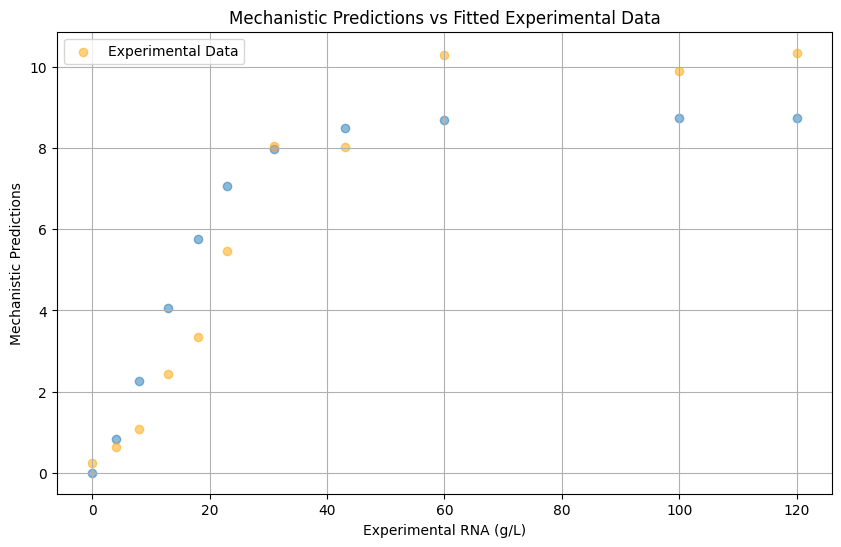

In [3]:
# plot the discrepancy predictions against the experimental data.
assimulo_model.set_predictions_configs(
    X_columns, is_sequence=True, verbose=False, initial_conditions=dict()
)
training_predictions = assimulo_model.predict(X_train.values)
plt.figure(figsize=(10, 6))
plt.scatter(
    X_train[schema.IVTReactionSchema.TIME_min.value].values,
    training_predictions,
    alpha=0.5,
)
plt.scatter(
    X_train[schema.IVTReactionSchema.TIME_min.value].values,
    y_train.values,
    color="orange",
    label="Experimental Data",
    alpha=0.5,
)
plt.xlabel("Experimental RNA (g/L)")
plt.ylabel("Mechanistic Predictions")
plt.title("Mechanistic Predictions vs Fitted Experimental Data")
plt.legend()
plt.grid()
plt.show()

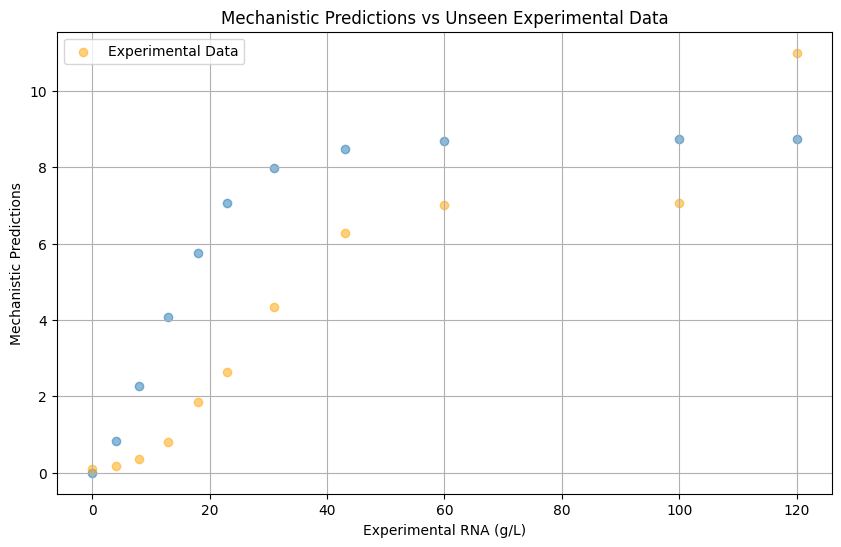

R2 Score: 0.4060


In [4]:
test_predictions = assimulo_model.predict(X_test.values)
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    test_predictions,
    alpha=0.5,
)
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    y_test.values,
    color="orange",
    label="Experimental Data",
    alpha=0.5,
)
plt.xlabel("Experimental RNA (g/L)")
plt.ylabel("Mechanistic Predictions")
plt.title("Mechanistic Predictions vs Unseen Experimental Data")
plt.legend()
plt.grid()
plt.show()

# Calculate and print the R2 score
r2 = r2_score(y_test.values, test_predictions)
print(f"R2 Score: {r2:.4f}")

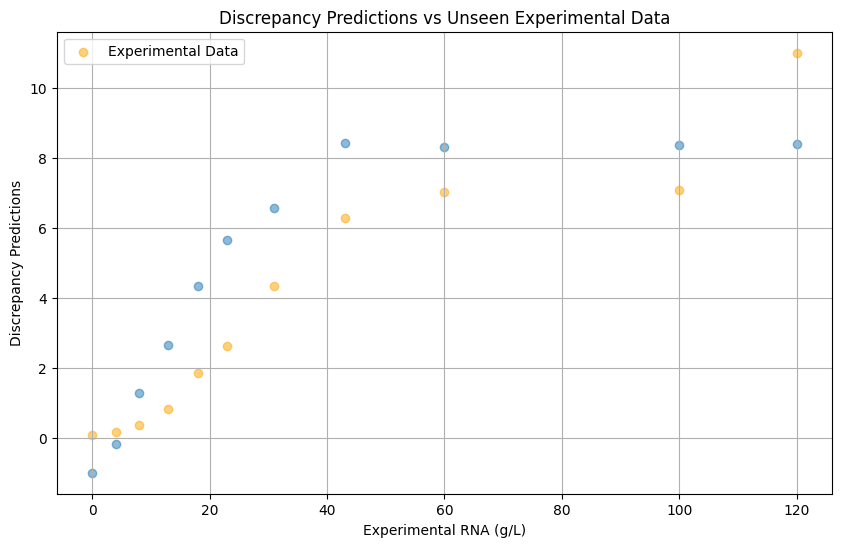

R2 Score of Discrepancy Predictions: 0.9035


In [5]:
# create residuals using the model predictions and build a discrepancy model from the residuals
discrepancy_model = DiscrepancyIVTModel(
    ml_model=xgboost.XGBRegressor(n_estimators=5),
    assimulo_model=assimulo_model,
    X_columns=X_columns,
)

discrepancy_model.fit(X_train[X_columns].values, y_train.values)

discrepancy_predictions = discrepancy_model.predict(X_test.values)
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    discrepancy_predictions,
    alpha=0.5,
)
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    y_test.values,
    color="orange",
    label="Experimental Data",
    alpha=0.5,
)
plt.xlabel("Experimental RNA (g/L)")
plt.ylabel("Discrepancy Predictions")
plt.title("Discrepancy Predictions vs Unseen Experimental Data")
plt.legend()
plt.grid()
plt.show()

r2_discrepancy = r2_score(y_train.values, discrepancy_predictions)
print(f"R2 Score of Discrepancy Predictions: {r2_discrepancy:.4f}")